In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [31]:
class Propitious:
    def __init__(self, w, alpha1, alpha2, L1, L2, beta=0.8, eps=0.8):
        self.w = w
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.L1 = L1
        self.L2 = L2
        self.beta = beta
        self.eps = eps
        
    def plot_alphas(self):
        plt.scatter(self.alpha1, self.alpha2, alpha=0.1)
        plt.xlabel(r'$\alpha_1$')
        plt.ylabel(r'$\alpha_2$')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.grid()
        plt.show()
        
    def create_figure(self, P):
        self.calc_UP_A1_A2(P)
        alpha1pref = [alpha1 for alpha1 in np.linspace(0, self.UP/self.A1, 100)]
        alpha2pref = [self.UP/self.A2 - alpha1 * self.A1/self.A2
                      for alpha1 in alpha1pref]
        
        C = self.average_cost(P)
        alpha1cost = [alpha1 for alpha1 in np.linspace(0, C/self.L1, 100)]
        alpha2cost = [C/L2 - alpha1 * L1/L2 for alpha1 in alpha1cost]
        
        plt.scatter(self.alpha1, self.alpha2, alpha=0.1)
        plt.plot(alpha1pref, alpha2pref, label='isopreference')
        plt.plot(alpha1cost, alpha2cost, label='isocost')
        plt.xlabel(r'$\alpha_1$')
        plt.ylabel(r'$\alpha_2$')
        plt.grid()
        plt.legend()
        plt.show()
        
    def utility(self, x):
        return x**(1 - self.eps) / (1 - self.eps)
        
    def calc_UP_A1_A2(self, P):
        self.UP = self.beta * (self.utility(self.w) - self.utility(self.w - P))
        self.A1 = self.utility(self.w - P) - self.utility(self.w - self.L1) + self.UP
        self.A2 = self.utility(self.w - P) - self.utility(self.w - self.L2) + self.UP

    def participation(self, P):
        self.calc_UP_A1_A2(P)
        return self.alpha1 * self.A1 + self.alpha2 * self.A2 - self.UP > 0
        
    def average_cost(self, P):
        insured = self.participation(P)
        N = sum(insured * (self.alpha1 * self.L1 + self.alpha2 * self.L2))
        D = sum(insured)
        return N / (D + 1e-16)
    
    def check_propitious_selection(self, price_change=1000):
        prices = np.arange(0, self.L1+1, price_change)
        average_costs = []
        old_cost = 0
        for price in prices:
            new_cost = self.average_cost(price)
            average_costs.append(new_cost)
            if new_cost < 1:
                return False
            if new_cost < old_cost:
                return True
            old_cost = new_cost
    
    def find_prices_propitious_selection(self, step=100):
        prices = np.arange(0, self.L1+1, step)
        old_cost = 0
        prices_propitious = []
        price_star, max_profit = 0, 0
        for price in prices:
            new_cost = self.average_cost(price)
            if new_cost < 1:
                return price_star, prices_propitious
            if new_cost < old_cost:
                prices_propitious.append(price - step)
            old_cost = new_cost
            profit = sum(self.participation(price)) * (price - new_cost)
            if profit > max_profit:
                max_profit = profit
                price_star = price
            
    def plot_average_cost_and_profit(self, step=100):
        prices = np.arange(0, self.L1+1, step)
        average_costs = []
        profits = []
        old_cost = 0
        for price in prices:
            new_cost = self.average_cost(price)
            average_costs.append(new_cost)
            profit = sum(self.participation(price)) * (price - new_cost)
            profits.append(profit)
            if new_cost < 1:
                break
        fig, ax1 = plt.subplots()
        
        color = 'tab:red'
        ax1.set_xlabel('price')
        ax1.set_ylabel('average_cost', color=color)
        ax1.plot(prices[:len(average_costs)], average_costs, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx() 
        color = 'tab:blue'
        ax2.set_ylabel('profit', color=color)
        ax2.plot(prices[:len(profits)], profits, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.grid()

        fig.tight_layout()
        plt.show()
        
def plot_propitious_selection(l_propitious):
    L1s = [L1 for L1, L2 in l_propitious]
    L2s = [L2 for L1, L2 in l_propitious]

    plt.scatter(L1s, L2s)
    plt.xlabel('L1')
    plt.ylabel('L2')
    plt.xlim([0, 100e3])
    plt.ylim([0, 100e3])
    plt.grid()
    plt.show()

# Income

In [21]:
df = pd.read_excel("..\data\compas_enquete_mll.xlsx")
df.totincome.describe()

count    1.296000e+03
mean     1.194043e+05
std      5.568754e+05
min      1.000000e+00
25%      4.500000e+04
50%      7.400000e+04
75%      1.050000e+05
max      1.500000e+07
Name: totincome, dtype: float64

# Using pr_nhome_compas
We adjust the probability of nursing home to be smaller or equal to the probablity of probability of survival to 85 years old.

In [32]:
df = pd.read_excel("..\data\compas_enquete_mll.xlsx")
df.rename(columns={'pr_nhome_compas': 'alpha1',
                   'pr_alive_85_compas': 'pi'},
          inplace=True)

print(f'prob dependency before 85: {(df.alpha1 > df.pi).mean()}')
df['alpha1'] = df[['alpha1', 'pi']].min(axis='columns')
df['alpha2'] = df.pi - df.alpha1
df['death'] = 1 - df.alpha1 - df.alpha2
df = df[['alpha1', 'alpha2', 'death']]
df.describe()

prob dependency before 85: 0.002


,alpha1,alpha2,death
count,2000.000000,2000.000000,2000.000000
mean,0.262085,0.385839,0.352076
std,0.112263,0.159902,0.119342
min,0.055000,0.000000,0.125000
25%,0.167500,0.267500,0.260000
50%,0.255000,0.332500,0.340000
75%,0.350000,0.562500,0.425625
max,0.522500,0.697500,0.937500


## Find propitious selection

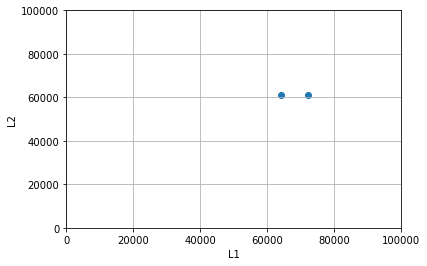

In [37]:
w = 72000

l_propitious_nhome = []
for L1 in np.arange(0, w + 1, 1000): # 1000
    for L2 in np.arange(0, L1, 1000): # 1000
        propitious = Propitious(w, df.alpha1, df.alpha2, L1, L2)
        if propitious.check_propitious_selection(price_change=800):
            l_propitious_nhome.append((L1, L2))
plot_propitious_selection(l_propitious_nhome)

In [40]:
from propitious import Propitious

In [42]:
for L1, L2 in l_propitious_nhome:
    propitious = Propitious(w, df.alpha1, df.alpha2, L1, L2)
    propitious_prices = propitious.find_prices_profits_propitious_selection(step=50)
    print(f'L1={L1}, L2={L2}')
    display(propitious_prices)    

L1=64000, L2=61000


,price,profit,remark
6,50350,9172428.0,max profit
0,58400,160710.0,propitious selection
1,58600,107742.0,propitious selection
2,58750,72155.0,propitious selection
3,58900,57000.0,propitious selection
4,59000,33144.0,propitious selection
5,59050,26813.0,propitious selection


L1=72000, L2=61000


,price,profit,remark
0,61050,30623933.0,propitious selection
1,61300,30655191.0,propitious selection
2,61650,30731677.0,propitious selection
3,61750,30742743.0,propitious selection
25,61800,30791618.0,max profit
4,61800,30792923.0,propitious selection
5,62450,29911686.0,propitious selection
6,62500,29914154.0,propitious selection
7,62800,29430310.0,propitious selection
8,63350,28342470.0,propitious selection


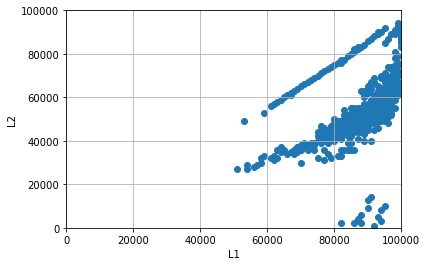

In [36]:
w = 100000

l_propitious_nhome = []
for L1 in np.arange(0, w + 1, 1000): # 1000
    for L2 in np.arange(0, L1, 1000): # 1000
        propitious = Propitious(w, df.alpha1, df.alpha2, L1, L2)
        if propitious.check_propitious_selection(price_change=500):
            l_propitious_nhome.append((L1, L2))
plot_propitious_selection(l_propitious_nhome)

## Find prices for which there is propitious selection
For each pair (L1, L2) for which we found propitious selection, the profit maximizing price and the prices for which there is propitious selection (average cost over the next price increase) are shown.

In [24]:
for L1, L2 in l_propitious_nhome:
    propitious = Propitious(w, df.alpha1, df.alpha2, L1, L2)
    propitious_prices = propitious.find_prices_propitious_selection(step=50)
    print(f'L1={L1}, L2={L2}')
    print(propitious_prices)    

## Specific example of propitious selection
We pick a pair (L1, L2) from the list above and show all the prices for which propitious selection occurs.

In [25]:
L1, L2 = l_propitious_nhome[6]
print(f'L1={L1}, L2={L2}')
propitious = Propitious(w, df.alpha1, df.alpha2, L1, L2)
_, prices = propitious.find_prices_propitious_selection(step=50)
for price in prices:
    print(price)
    propitious.create_figure(price)

IndexError: list index out of range

In [ ]:
prices = np.arange(65000, 67000, step=50)
average_costs = [propitious.average_cost(P) for P in prices]
s = pd.Series(average_costs, index=prices)
s.plot(grid=True, xlabel='price', ylabel='average cost', title='Example(s) of propitious selection')
plt.show()

# Using pr_adl_compas but only with prob adl < prob survival
The observations for which the probability of ADL is higher than the probability of survival to 85 are removed form the sample.

In [ ]:
df = pd.read_excel("..\data\compas_enquete_mll.xlsx")
df.rename(columns={'pr_adl_compas': 'alpha1',
                   'pr_alive_85_compas': 'pi'},
          inplace=True)

print(f'prob health issues before 85: {(df.alpha1 > df.pi).mean()}')
df = df[df.alpha1 <= df.pi]
df['alpha2'] = df.pi - df.alpha1
df['death'] = 1 - df.alpha1 - df.alpha2
df = df[['alpha1', 'alpha2', 'death']]
df.describe()

## Find propitious selection

In [ ]:
w = 100000

l_propitious_adl_corrected = []
for L1 in np.arange(0, w + 1, 1000):
    for L2 in np.arange(0, L1, 1000):
        propitious = Propitious(w, df.alpha1, df.alpha2, L1, L2)
        if propitious.check_propitious_selection():
            l_propitious_adl_corrected.append((L1, L2))
plot_propitious_selection(l_propitious_adl_corrected)

## Find prices for which there is propitious selection

In [ ]:
for L1, L2 in l_propitious_adl_corrected:
    propitious = Propitious(w, df.alpha1, df.alpha2, L1, L2)
    propitious_prices = propitious.find_prices_propitious_selection(step=50)
    print(f'L1={L1}, L2={L2}')
    print(propitious_prices)    

## Specific example of propitious selection

In [ ]:
L1, L2 = l_propitious_adl_corrected[124]
print(f'L1={L1}, L2={L2}')
propitious = Propitious(w, df.alpha1, df.alpha2, L1, L2)
_, prices = propitious.find_prices_propitious_selection(step=50)
for price in prices:
    print(price)
    propitious.create_figure(price)

In [ ]:
prices = np.arange(88500, 90000, step=50)
average_costs = [propitious.average_cost(P) for P in prices]
s = pd.Series(average_costs, index=prices)
s.plot(grid=True, xlabel='price', ylabel='average cost', title='Example(s) of propitious selection')
plt.show()

# Using pr_adl_compas
We adjust the probability of adl to be smaller or equal to the probablity of probability of survival to 85 years old.

In [ ]:
df = pd.read_excel("..\data\compas_enquete_mll.xlsx")
df.rename(columns={'pr_adl_compas': 'alpha1',
                   'pr_alive_85_compas': 'pi'},
          inplace=True)

print(f'prob dependency before 85: {(df.alpha1 > df.pi).mean()}')
df['alpha1'] = df[['alpha1', 'pi']].min(axis='columns')
df['alpha2'] = df.pi - df.alpha1
df['death'] = 1 - df.alpha1 - df.alpha2
df = df[['alpha1', 'alpha2', 'death']]
df.describe()

## Find propitious selection

In [ ]:
w = 100000

l_propitious_adl = []
for L1 in np.arange(0, w + 1, 1000):
    for L2 in np.arange(0, L1, 1000):
        propitious = Propitious(w, df.alpha1, df.alpha2, L1, L2)
        if propitious.check_propitious_selection():
            l_propitious_adl.append((L1, L2))
plot_propitious_selection(l_propitious_adl)

## Find prices for which there is propitious selection

In [ ]:
for L1, L2 in l_propitious_adl:
    propitious = Propitious(w, df.alpha1, df.alpha2, L1, L2)
    propitious_prices = propitious.find_prices_propitious_selection(step=50)
    print(f'L1={L1}, L2={L2}')
    print(propitious_prices)    

## Specific example of propitious selection

In [ ]:
L1, L2 = l_propitious_adl[70]
print(f'L1={L1}, L2={L2}')
propitious = Propitious(w, df.alpha1, df.alpha2, L1, L2)
_, prices = propitious.find_prices_propitious_selection(step=50)
for price in prices:
    print(price)
    propitious.create_figure(price)

In [ ]:
prices = np.arange(89500, 90500, step=50)
average_costs = [propitious.average_cost(P) for P in prices]
s = pd.Series(average_costs, index=prices)
s.plot(grid=True, xlabel='price', ylabel='average cost', title='Example(s) of propitious selection')
plt.show()